In [8]:
%pylab inline
plt.style.use("bmh")
import pandas as pd
import numpy as np
import pathlib
import matplotlib as mpl
import torch

import datetime
from Estimator import forcast,retrieve_data,train,calculate_loss

from torch.utils.data import DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler

from torch import optim,device,cuda

from ElectricityLoadDataset import ElectricityLoadDataset
from Models import MQRNN
from utils import quantile_loss


Populating the interactive namespace from numpy and matplotlib


In [9]:

DATA_DIR = pathlib.Path("data")
MODEL_DIR = pathlib.Path("models")
GRAPH_DIR = pathlib.Path("graphs")
device = device('cuda:0') if cuda.is_available() else device('cpu')

input_size = 1  # y
embed_size = 9 # x
hidden_size = 30  # for lstm: "both with a state dimension of 30"
context_size = 12  # for c_t/c_a
horizon = 24
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

samples = 10

batch_size = 32
random_seed = 42

print_every = 50
epochs = 2


# Comparisons the model performance

Run examples where $n = 10$, where the play made with for the features, and if and how many deep layers. 


## Performance comparison by the features

The night / day cycle varies between summer and winter (see the gramph at the notebook's bottom).
All the features together try to create more cycle information. 


**Full calendar features ($x_h,x_f$):**
1. yearly_cycle = np.sin(2 * np.pi * df.index.dayofyear / 366)

2. weekly_cycle= np.sin(2 * np.pi * df.index.dayofweek / 7)

3. daily_cycle= np.sin(2 * np.pi * df.index.hour / 24)

4. weekend= (df.index.dayofweek < 5).astype(float)

5. night = ((df.index.hour < 7) & (df.index.hour>21)).astype(float)

6. winter = ((df.index.month < 4) & (df.index.month > 10)).astype(float)

7. Holiday = ((df.index.is_year_end | df.index.is_year_start) | (( df.index.month==12) & (df.index.daysinmonth==25))).astype(float)

8. winter_daily_cycle =daily_cycle*winter
9. summer_daily_cycle =daily_cycle*(1-winter)


`calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle", "weekend", "night", "winter", "Holiday", "summer_daily_cycle", "winter_daily_cycle"]`

The default all the 9 calendar_features: `ElectricityLoadDataset(df, samples,,features=np.arange(9))` 

and accordingly:  `retrieve_data(samples=samples,features=np.arange(9))`

### Model with all 9 calendar_features

In [3]:

data_loaders = retrieve_data(samples=samples)
model = MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=10, batch=32, printing training loss every 50*32=1600 samples
2021-03-06 08:18:30.978705 Starting epoch 1 / 2
2021-03-06 08:19:49.843216 t = 50, loss = 0.0748
2021-03-06 08:21:19.770360 Got average loss of (0.07)
2021-03-06 08:21:19.772353 Starting epoch 2 / 2
2021-03-06 08:22:40.509296 t = 50, loss = 0.0742
2021-03-06 08:24:08.707299 Got average loss of (0.06)

 The Average loss: 0.0526


### Model with 3 base calendar_features

`calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle"]`

In [4]:
embed_size=3
features_num=range(3)
data_loaders = retrieve_data(samples=samples,features=features_num)
model = MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=10, batch=32, printing training loss every 50*32=1600 samples
2021-03-06 08:24:18.050698 Starting epoch 1 / 2
2021-03-06 08:25:50.121159 t = 50, loss = 0.0768
2021-03-06 08:27:30.577201 Got average loss of (0.07)
2021-03-06 08:27:30.579196 Starting epoch 2 / 2
2021-03-06 08:28:49.929239 t = 50, loss = 0.0681
2021-03-06 08:30:19.486660 Got average loss of (0.07)

 The Average loss: 0.0757


### Model with 3 base calendar_features and 3 logical 

calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle", "night", "winter", "Holiday"]

In [6]:
embed_size=6
data_loaders = retrieve_data(samples=samples,features=range(6))
model = MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=10, batch=32, printing training loss every 50*32=1600 samples
2021-03-06 08:31:03.592851 Starting epoch 1 / 2
2021-03-06 08:32:24.992988 t = 50, loss = 0.0661
2021-03-06 08:33:55.638795 Got average loss of (0.07)
2021-03-06 08:33:55.641786 Starting epoch 2 / 2
2021-03-06 08:35:18.381686 t = 50, loss = 0.0546
2021-03-06 08:36:44.716941 Got average loss of (0.06)

 The Average loss: 0.0698


## Performance comparison: adding a deep layer to the decoder 



The default `deep_global_mlp=0` and `deep_local_mlp=0` 


###  Global and local mlp with 1 deep layer 


In [10]:
deep_local_mlp=1
deep_global_mlp=1
embed_size=9

data_loaders = retrieve_data(samples=samples)
model =  MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles,deep_local_mlp,deep_global_mlp).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=10, batch=32, printing training loss every 50*32=1600 samples
2021-03-06 08:37:15.448565 Starting epoch 1 / 2
2021-03-06 08:38:34.368946 t = 50, loss = 0.0788
2021-03-06 08:40:08.607998 Got average loss of (0.08)
2021-03-06 08:40:08.611986 Starting epoch 2 / 2
2021-03-06 08:41:45.158152 t = 50, loss = 0.0614
2021-03-06 08:43:30.138590 Got average loss of (0.07)

 The Average loss: 0.0586


### Local mlp with 1 deep layer 


In [11]:
deep_local_mlp=1
deep_global_mlp=0
model =  MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles,deep_local_mlp,deep_global_mlp).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=10, batch=32, printing training loss every 50*32=1600 samples
2021-03-06 08:43:32.513181 Starting epoch 1 / 2
2021-03-06 08:44:55.956236 t = 50, loss = 0.0747
2021-03-06 08:46:29.509735 Got average loss of (0.08)
2021-03-06 08:46:29.512728 Starting epoch 2 / 2
2021-03-06 08:47:53.623929 t = 50, loss = 0.0612
2021-03-06 08:49:22.889337 Got average loss of (0.07)

 The Average loss: 0.0513


### Global mlp with 1 deep layer 

In [12]:
deep_local_mlp=0
deep_global_mlp=1
model =  MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles,deep_local_mlp,deep_global_mlp).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=10, batch=32, printing training loss every 50*32=1600 samples
2021-03-06 08:49:44.386715 Starting epoch 1 / 2
2021-03-06 08:51:06.805570 t = 50, loss = 0.0756
2021-03-06 08:52:39.091201 Got average loss of (0.07)
2021-03-06 08:52:39.093197 Starting epoch 2 / 2
2021-03-06 08:54:05.861564 t = 50, loss = 0.0859
2021-03-06 08:55:41.106108 Got average loss of (0.07)

 The Average loss: 0.0516


## Performance comparison by the contexts dimensions

## context_size = 20 

In [13]:
deep_local_mlp=0
deep_global_mlp=0
context_size = 20 

model =  MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles,deep_local_mlp,deep_global_mlp).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=10, batch=32, printing training loss every 50*32=1600 samples
2021-03-06 08:55:43.253364 Starting epoch 1 / 2
2021-03-06 08:57:06.583338 t = 50, loss = 0.0767
2021-03-06 08:58:35.553454 Got average loss of (0.07)
2021-03-06 08:58:35.556443 Starting epoch 2 / 2
2021-03-06 08:59:57.030707 t = 50, loss = 0.0554
2021-03-06 09:01:27.357782 Got average loss of (0.06)

 The Average loss: 0.0564


## context_size = 5 

In [14]:

context_size = 5 

model =  MQRNN(input_size, embed_size, hidden_size, context_size, horizon, quantiles,deep_local_mlp,deep_global_mlp).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, verbose=True)
train(model, data_loaders, optimizer, scheduler, num_epochs=epochs)
model.eval()
dataiter = iter(data_loaders[2])
enc_data, dec_data = dataiter.next()
print("\n","The Average loss:",calculate_loss(model, enc_data, dec_data).cpu().detach().numpy().round(4))

Training info: samples=10, batch=32, printing training loss every 50*32=1600 samples
2021-03-06 09:01:29.113864 Starting epoch 1 / 2
2021-03-06 09:02:49.937647 t = 50, loss = 0.0855
2021-03-06 09:04:16.741794 Got average loss of (0.08)
2021-03-06 09:04:16.743789 Starting epoch 2 / 2
2021-03-06 09:05:42.505080 t = 50, loss = 0.0774
2021-03-06 09:07:12.302289 Got average loss of (0.07)

 The Average loss: 0.0662


# The average consumption across all 370 households - a graphical summary

In [15]:
eldata = pd.read_csv('data\LD2011_2014.txt',
                 parse_dates=[0],
                 delimiter=";",
                 decimal=",")
eldata.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)


eldata=eldata.resample('H', on='timestamp').mean().reset_index()


**Averaged over 370 households**

Only for values> 0

In [16]:
el_mean=eldata[eldata!=0].set_index("timestamp").mean(axis=1)


**An illustration of the winter-summer cycles**

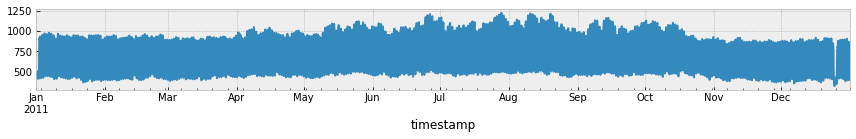

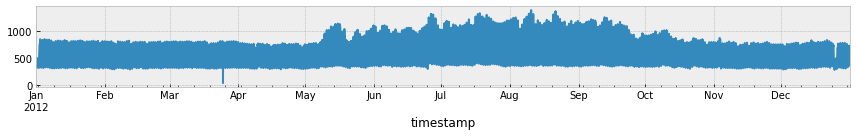

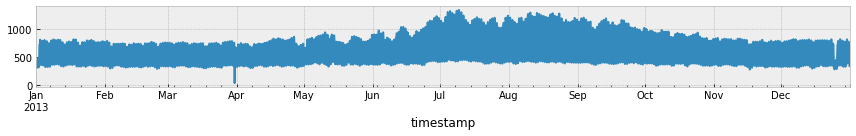

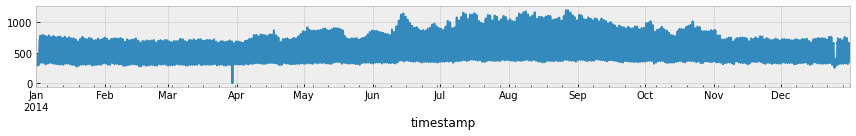

In [17]:

for year in ["2011","2012","2013","2014"]:
    plt.figure(figsize=(12,2))
    el_mean.loc[year].plot(ax=plt.gca())
    plt.tight_layout()
    plt.show()

Illustration of the yearly cycle. The cycle of peak consumption and minimum consumption is different.

To improve the predictive performance, we have added features of the general day/night cycle, day/night cycle for winter (in the summer is zero), and day and night cycle for summer  (in the winter is zero).

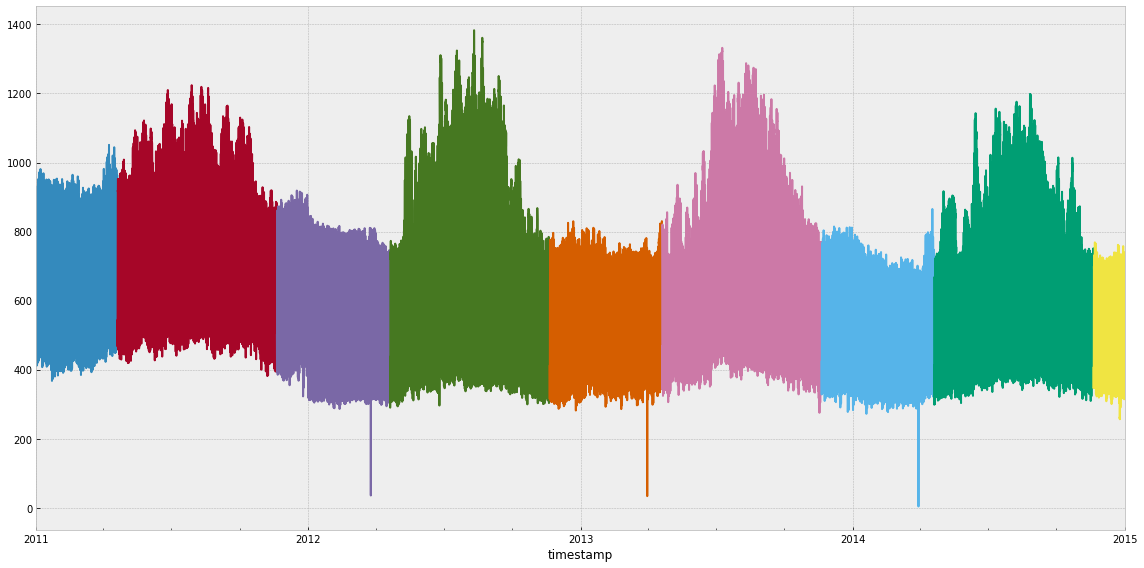

In [18]:
plt.figure(figsize=(16,8))
el_mean.loc["2011-1-1":"2011-4-19"].plot()
el_mean.loc["2011-4-20":"2011-11-19"].plot()
el_mean.loc["2011-11-20":"2012-4-19"].plot()
el_mean.loc["2012-4-20":"2012-11-19"].plot()

el_mean.loc["2012-11-20":"2013-4-19"].plot()
el_mean.loc["2013-4-20":"2013-11-19"].plot()

el_mean.loc["2013-11-20":"2014-4-19"].plot()
el_mean.loc["2014-4-20":"2014-11-19"].plot()
el_mean.loc["2014-11-20":"2015-1-31"].plot()


plt.tight_layout()

NOTE:
"Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points." 

Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.



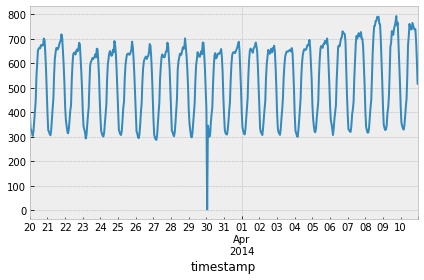

In [19]:
el_mean.loc["2014-3-20":"2014-4-10"].plot()

plt.tight_layout()

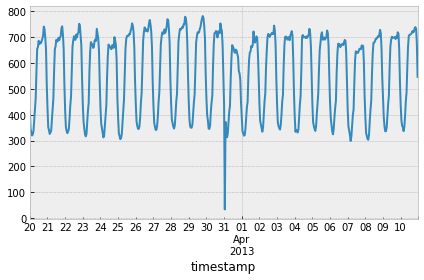

In [20]:
el_mean.loc["2013-3-20":"2013-4-10"].plot()

plt.tight_layout()



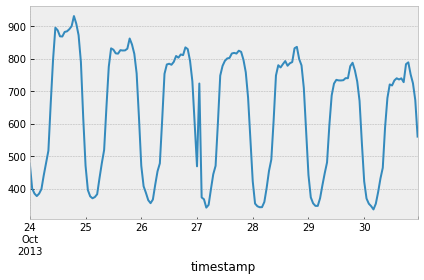

In [21]:
el_mean.loc["2013-10-24":"2013-10-30"].plot()

plt.tight_layout()


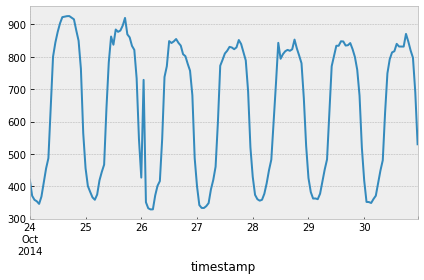

In [22]:
el_mean.loc["2014-10-24":"2014-10-30"].plot()

plt.tight_layout()
